<p style="font-family: Arial; font-size:2.5em;color:purple; font-style:bold"><br>
INFS 772 Spring 2019 Assignment 2<br><br>Data Manipulation with Pandas
</p><br>

## Due Friday, Mar. 1, 11:59 PM

### The learning objectives of this assignment are:

1. To practice data manipulation with Pandas
1. To understand the interplay of **precision**, **accuracy**, and **bias** when making predictions


### Instructions

The questions in this assignment are numbered. The questions are also usually italicised, to help you find them in the flow of this notebook. At some points you will be asked to write functions to carry out certain tasks. Its worth reading a little ahead to see how the function whose body you will fill in will be used.


The data for this homework can be downloaded on our D2L site. Unzip them (as a folder named data) to the same folder where you are running this notebook. You should find the following files there:

1. us-states.json
2. electoral_votes.csv
3. predictwise.csv
4. g12.csv
5. g08.csv
6. 2008results.csv
7. nat.csv
8. p04.csv
9. 2012results.csv
10. cleaned-state_data2012.csv

#### Setup and Plotting code

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Here is some code to plot [State Chloropleth](http://en.wikipedia.org/wiki/Choropleth_map) maps in matplotlib. `make_map` is the function you will use.

In [3]:
#load in state geometry
state2poly = defaultdict(list)

data = json.load(open("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

## Today: the day we make the prediction

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

## Background: The Electoral College

US Presidential elections revolve around the <a href="http://en.wikipedia.org/wiki/Electoral_College_(United_States)"> Electoral College </a>. In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President. 

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.) 

Here is the electoral vote breakdown by state:

*As a matter of convention, we will index all our dataframes by the state name*

In [5]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


To illustrate the use of `make_map` we plot the Electoral College

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


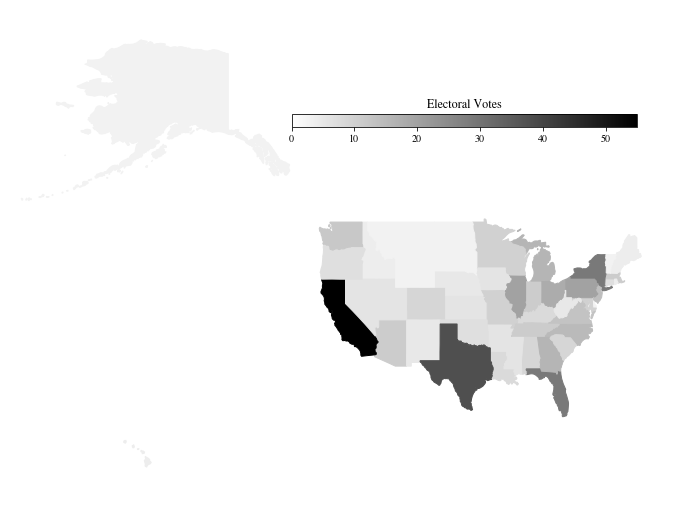

In [6]:
make_map(electoral_votes.Votes, "Electoral Votes");

## Question 1: Simulating elections

#### The PredictWise Baseline

We will start by examining a successful forecast that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012. This will give us a point of comparison for our own forecast models.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

In [7]:
!type data\predictwise.csv
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

Obama,Romney,States,Votes
0.0,1.0,Alabama,9
0.0,1.0,Alaska,3
0.062,0.938,Arizona,11
0.0,1.0,Arkansas,6
1.0,0.0,California,55
0.807,0.193,Colorado,9
1.0,0.0,Connecticut,7
1.0,0.0,Delaware,3
1.0,0.0,District of Columbia,3
0.72,0.28,Florida,29
0.004,0.996,Georgia,16
1.0,0.0,Hawaii,4
0.0,1.0,Idaho,4
1.0,0.0,Illinois,20
0.036000000000000004,0.9640000000000001,Indiana,11
0.8370000000000001,0.163,Iowa,6
0.0,1.0,Kansas,6
0.0,1.0,Kentucky,8
0.0,1.0,Louisiana,8
1.0,0.0,Maine,4
1.0,0.0,Maryland,10
1.0,0.0,Massachusetts,11
0.987,0.013000000000000001,Michigan,16
0.982,0.018000000000000002,Minnesota,10
0.0,1.0,Mississippi,6
0.07400000000000001,0.9259999999999999,Missouri,10
0.046,0.9540000000000001,Montana,3
0.0,1.0,Nebraska,5
0.851,0.149,Nevada,6
0.857,0.14300000000000002,New Hampshire,4
0.998,0.002,New Jersey,14
0.985,0.015,New Mexico,5
1.0,0.0,New York,29
0.349,0.6509999999999999,North Carolina,15
0.025,0.975,North Dakota,3
0.89,0.11,Ohio,18
0.0,1.0,Oklahoma,7
0.976,0.024,Oregon,7
0.978,0.0220000

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">

**1.1** Each row is the probability predicted by Predictwise that Romney or Obama would win a state. The votes column lists the number of electoral college votes in that state. *Use `make_map` to plot a map of the probability that Obama wins each state, according to this prediction*.</p>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


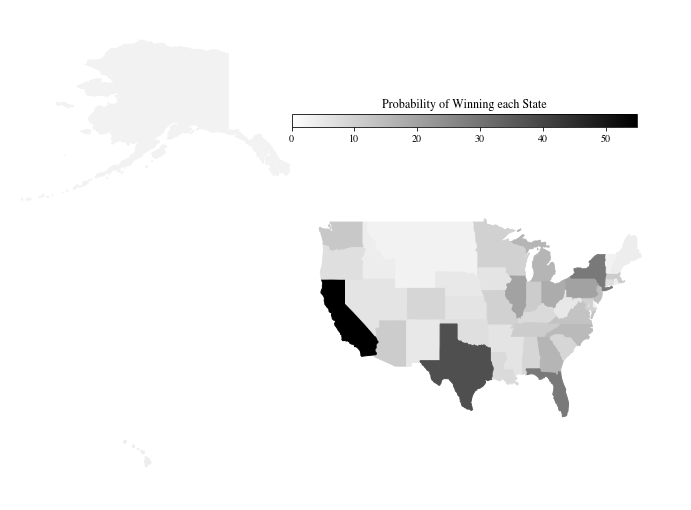

In [8]:
#This will plot a map of the probability that Obama wins each state
make_map(predictwise.Votes, "Probability of Winning each State");

Later on in this homework we will explore some approaches to estimating probabilities like these and quatifying our uncertainty about them. But for the time being, we will focus on how to make a prediction assuming these probabilities are known.

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty. From these simulations, we will be able to make a prediction about the expected outcome of the election, and make a statement about how sure we are about it.

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.2** We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities. *Write a function that uses this **predictive model** to simulate the outcome of the election given a Dataframe of probabilities*.</p>

In [9]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""

def simulate_election(model, n_sim):
    #each column simulates a single outcome from the 50 states + DC
    #Obama wins the simulation if the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)


The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. We use the results to compute the probability, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [10]:
result = simulate_election(predictwise, 10000)
result  
    

array([322, 318, 347, ..., 343, 332, 347], dtype=int64)

In [11]:
#compute the probability of an Obama win, given this simulation
def election_prob(simulation,no_simulations):
    count =0
    #Iterates through the electoral college votes to count instances of 269 or more votes.
    for i in range(no_simulations):
        
        votes = simulation[i]
            
        if votes >= 269:
            count +=1
    
    return count/no_simulations
string = 'The probability of Obama receiving 269 or more electoral college votes is:'
print(string,np.round(election_prob(result,10000)*100,2),'%')


The probability of Obama receiving 269 or more electoral college votes is: 99.62 %


**1.3** **Now, write a function called `plot_simulation` to visualize the simulation**. This function should:

* Build a histogram from the result of simulate_election
* Overplot the "victory threshold" of 269 votes as a vertical black line (hint: use axvline)
* Overplot the result (Obama winning 332 votes) as a vertical red line
* Compute the number of votes at the 5th and 95th quantiles, and display the difference (this is an estimate of the outcome's uncertainty)
* Display the probability of an Obama victory    
    

In [12]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes Obama wins in each simulation.
    
Returns
-------
Nothing 
"""

def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()


Lets plot the result of the Predictwise simulation. Your plot should look something like this:

<img src="http://i.imgur.com/uCOFXHp.png">

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


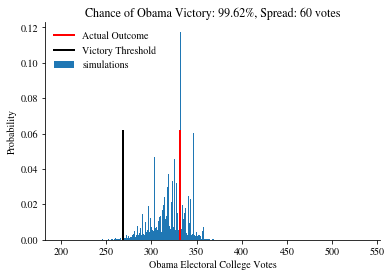

In [13]:
plot_simulation(result)

#### Evaluating and Validating our Forecast

The point of creating a probabilistic predictive model is to simultaneously make a forecast and give an estimate of how certain we are about it. 

However, in order to trust our prediction or our reported level of uncertainty, the model needs to be *correct*. We say a model is *correct* if it honestly accounts for all of the mechanisms of variation in the system we're forecasting.

In this section, we **evaluate** our prediction to get a sense of how useful it is, and we **validate** the predictive model by comparing it to real data.

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.4** Suppose that we believe the model is correct. Under this assumption, we can **evaluate** our prediction by characterizing its **accuracy** and **precision** (see [here](http://celebrating200years.noaa.gov/magazine/tct/accuracy_vs_precision_556.jpg) for an illustration of these ideas). *What does the above plot reveal about the **accuracy** and **precision** of the PredictWise model?*</p>

It reveals that this PredictWise model is both high accurate and and high precision as a majority of the values are clustered between 300 and 350.

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.5** Unfortunately, we can never be *absolutely sure* that a model is correct, just as we can never be absolutely sure that the sun will rise tomorrow. But we can test a model by making predictions assuming that it is true and comparing it to real events -- this constitutes a hypothesis test. After testing a large number of predictions, if we find no evidence that says the model is wrong, we can have some degree of confidence that the model is right (the same reason we're still quite confident about the sun being here tomorrow). We call this process **model checking**, and use it to **validate** our model.

*Describe how the graph provides one way of checking whether the prediction model is correct. How many predictions have we checked in this case? How could we increase our confidence in the model's correctness?*</p>

There have been 10000 simulations or predictions were checked; We can increase confidence in the model's correction by using cross-validation.

### Gallup Party Affiliation Poll

Now we will try to **estimate** our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. [Here's the data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [14]:
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Each row lists a state, the percent of surveyed individuals who identify as Democrat/Republican, the percent whose identification is unknown or who haven't made an affiliation yet, the margin between Democrats and Republicans (`Dem_Adv`: the percentage identifying as Democrats minus the percentage identifying as Republicans), and the number `N` of people surveyed.

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.6** This survey can be used to predict the outcome of each State's election. The simplest forecast model assigns 100% probability that the state will vote for the majority party.  *Implement this simple forecast*.</p>

In [15]:
"""
Function
--------
simple_gallup_model

A simple forecast that predicts an Obama (Democratic) victory with
0 or 100% probability, depending on whether a state
leans Republican or Democrat.

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama. All values should be 0 or 1
    model.index should be set to gallup.index (that is, it should be indexed by state name)
    
Examples
---------
>>> simple_gallup_model(gallup_2012).ix['Florida']
Obama    1
Name: Florida, dtype: float64
>>> simple_gallup_model(gallup_2012).ix['Arizona']
Obama    0
Name: Arizona, dtype: float64
"""


def simple_gallup_model(gallup):  
   
    new_gallup = pd.DataFrame(index=gallup.index.values, columns = ['Obama'])
    new_gallup.iloc[0:0]
    new_gallup['Obama'] = 0
    new_gallup.Obama.astype('int64')
    new_gallup['Obama'] = np.where(gallup['Dem_Adv'] < 1, 0, 1)
    return new_gallup
 
   


 





Now, we run the simulation with this model, and plot it.

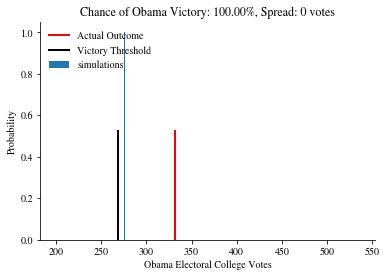

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


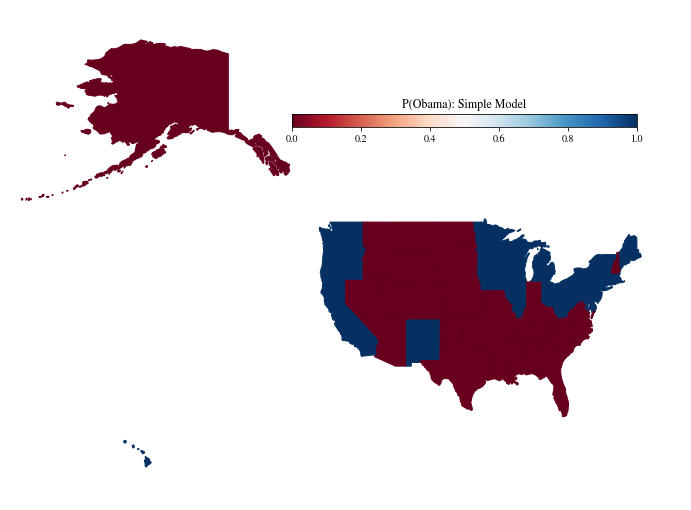

In [16]:
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.7** Attempt to **validate** the predictive model using the above simulation histogram. *Does the evidence contradict the predictive model?*</p>

While the evidence predict victory as well, there is some contradiction. The evidence skews loser to the victory threshold while the model simulations skew closer to the actual outcome.

#### Adding Polling Uncertainty to the Predictive Model

The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. This is clearly wrong -- there are numerous sources of uncertainty in estimating election outcomes from a poll of affiliations. 

The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll *everybody* in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce?

On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. (The calculation of the sampling error itself is an exercise in statistics. Its fun to think of how you could arrive at the sampling error if it was not given to you. One way to do it would be to assume this was a two-choice situation and use binomial sampling error for the non-unknown answers, and further model the error for those who answered 'Unknown'.)

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.8** Use Gallup's estimate of 3% to build a Gallup model with some uncertainty. Assume that the `Dem_Adv` column represents the mean of a Gaussian, whose standard deviation is 3%. Build the model in the function `uncertain_gallup_model`. *Return a forecast where the probability of an Obama victory is given by the probability that a sample from the `Dem_Adv` Gaussian is positive.*
</p>

**Hint**
The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Cumulative Distribution Function of a Gaussian:

$$
CDF(z) = \frac1{2}\left(1 + {\rm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) 
$$


In [17]:
"""
Function
--------
uncertain_gallup_model

A forecast that predicts an Obama (Democratic) victory if the random variable drawn
from a Gaussian with mean Dem_Adv and standard deviation 3% is >0

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama.
    model.index should be set to gallup.index (that is, it should be indexed by state name)
"""

from scipy.special import erf

def uncertain_gallup_model(gallup):  
   
    new_gallup = pd.DataFrame(index=gallup.index.values, columns = ['Obama'])
    new_gallup.iloc[0:0]
    new_gallup['Obama'] = 0
    new_gallup.Obama.astype('int64')
    new_gallup['Obama'] = np.where(erf(gallup.Dem_Adv) < 1, 0, 1) 
    return new_gallup




We construct the model by estimating the probabilities:

In [18]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(electoral_votes)

Once again, we plot a map of these probabilities, run the simulation, and display the results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


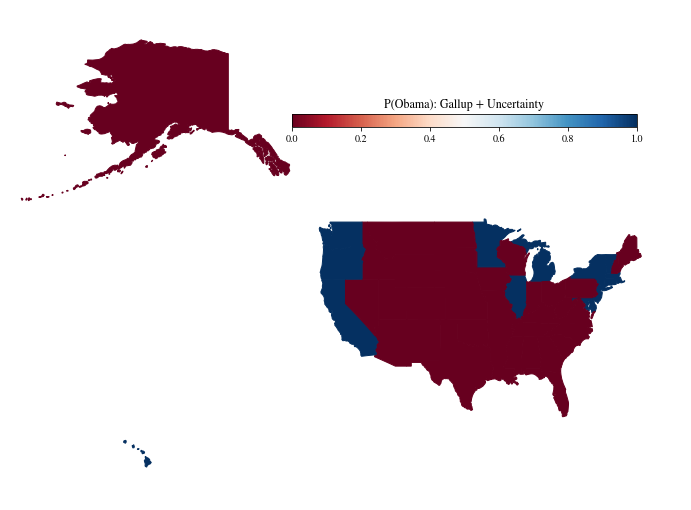

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


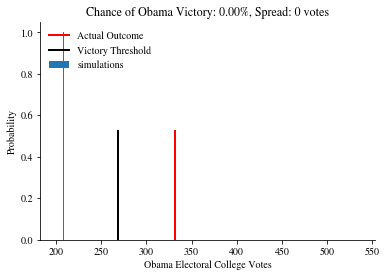

In [19]:
make_map(model.Obama, "P(Obama): Gallup + Uncertainty")
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.9**  *Attempt to **validate** the above model using the histogram. Does the predictive distribution appear to be consistent with the real data? Comment on the accuracy and precision of the prediction.*</p>

The predictive distribution does not appear to be consistent with the real data.  It is well below the victory threshold was well as the actual outcome.  Based on this, it can be determined that while it is precise, it is not accurate.

#### Biases

While accounting for uncertainty is one important part of making predictions, we also want to avoid systematic errors. We call systematic over- or under-estimation of an unknown quantity **bias**. In the case of this forecast, our predictions would be biased if the estimates from this poll *systematically* over- or under-estimate vote proportions on election day. There are several reasons this might happen:

1. **Gallup is wrong**. The poll may systematically over- or under-estimate party affiliation. This could happen if the people who answer Gallup phone interviews might not be a representative sample of people who actually vote, Gallup's methodology is flawed, or if people lie during a Gallup poll.
1. **Our assumption about party affiliation is wrong**. Party affiliation may systematically over- or under-estimate vote proportions. This could happen if people identify with one party, but strongly prefer the candidate from the other party, or if undecided voters do not end up splitting evenly between Democrats and Republicans on election day.
1. **Our assumption about equilibrium is wrong**. This poll was released in August, with more than two months left for the elections. If there is a trend in the way people change their affiliations during this time period (for example, because one candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.

One way to account for bias is to calibrate our model by estimating the bias and adjusting for it. Before we do this, let's explore how sensitive our prediction is to bias.

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.10** *Implement a `biased_gallup` forecast, which assumes the vote share for the Democrat on election day will be equal to `Dem_Adv` shifted by a fixed negative amount.* We will call this shift the "bias", so a bias of 1% means that the expected vote share on election day is `Dem_Adv`-1.</p>

**Hint**  You can do this by wrapping the `uncertain_gallup_model` in a function that modifies its inputs.

In [20]:
"""
Function
--------
biased_gallup

Subtracts a fixed amount from Dem_Adv, beofore computing the uncertain_gallup_model.
This simulates correcting a hypothetical bias towards Democrats
in the original Gallup data.

Inputs
-------
gallup : DataFrame
    The Gallup party affiliation data frame above
bias : float
    The amount by which to shift each prediction
    
Examples
--------
>>> model = biased_gallup(gallup, 1.)
>>> model.ix['Flordia']
>>> .460172
"""
def biased_gallup(gallup,bias):  
   
    new_gallup = pd.DataFrame(index=gallup.index.values, columns = ['Obama'])
    new_gallup.iloc[0:0]
    new_gallup['Obama'] = 0
    new_gallup.Obama.astype('int64')
    new_gallup['Obama'] = erf(gallup.Dem_Adv-bias)
    return new_gallup


**1.11** *Simulate elections assuming a bias of 1% and 5%, and plot histograms for each one.*

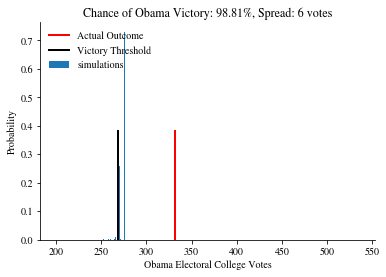

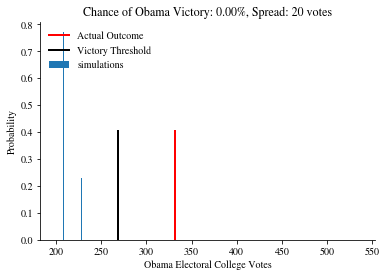

In [21]:
model = biased_gallup(gallup_2012, 1)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

model = biased_gallup(gallup_2012, 5)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()


Note that even a small bias can have a dramatic effect on the predictions. Pundits made a big fuss about bias during the last election, and for good reason -- it's an important effect, and the models are clearly sensitive to it. Forecastors like Nate Silver would have had an easier time convincing a wide audience about their methodology if bias wasn't an issue.

Furthermore, because of the nature of the electoral college, biases get blown up large. For example, suppose you mis-predict the party Florida elects. We've possibly done this as a nation in the past :-). Thats 29 votes right there. So, the penalty for even one misprediction is high.

#### Estimating the size of the bias from the 2008 election

While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct *if* we are able to estimate the size of the bias and adjust for it. This is one form of **calibration**.

One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.

In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [22]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


**1.12** *Make a scatter plot using the `prediction_08` dataframe of the democratic advantage in the 2008 Gallup poll (X axis) compared to the democratic win percentage -- the difference between Obama and McCain's vote percentage -- in the election (Y Axis). Overplot a linear fit to these data.*

**Hint**
The `np.polyfit` function can compute linear fits, as can `sklearn.linear_model.LinearModel`

[  1.26390486 -11.32855786]


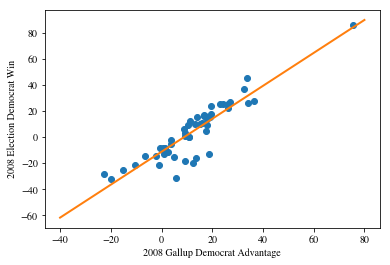

In [23]:
plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel("2008 Gallup Democrat Advantage")
plt.ylabel("2008 Election Democrat Win")
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)
print(fit)


Notice that a lot of states in which Gallup reported a Democratic affiliation, the results were strongly in the opposite direction. Why might that be? You can read more about the reasons for this [here](http://www.gallup.com/poll/114016/state-states-political-party-affiliation.aspx#1).

<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">A quick look at the graph will show you a number of states where Gallup showed a Democratic advantage, but where the elections were lost by the democrats. Use Pandas to list these states.</p>

In [24]:
cond1 = prediction_08.Dem_Adv > 0
cond2 = prediction_08.Dem_Win < 0

gallup_final = prediction_08[cond1 & cond2]
gallup_final



,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


We compute the average difference between the Democrat advantages in the election and Gallup poll

In [25]:
print((prediction_08.Dem_Adv - prediction_08.Dem_Win).mean())

8.068039215686275


<p style="font-family: Arial; font-size:1.25em;color:blue; font-style:bold">**1.13** * **Calibrate** your forecast of the 2012 election using the estimated bias from 2008. Validate the resulting model against the real 2012 outcome. Did the calibration help or hurt your prediction?*</p>

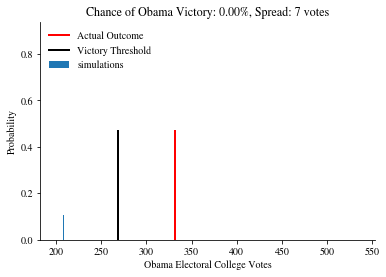

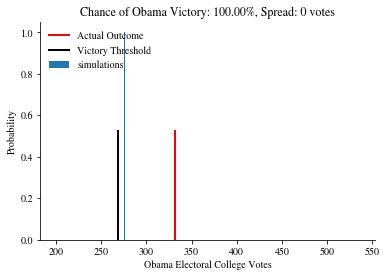

In [26]:
#2012 election forecast with estimated 2008 bias
model = biased_gallup(gallup_2012, 8)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

#original 2012 election forecast
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()



Based on the plots, it can be confirmed that the calibration hurt the prediction.

## How to submit

To submit your homework, create a folder named lastname_firstname_2 and place this notebook file in the folder. Also put the data folder in this folder. Make sure everything still works! Select Kernel->Restart Kernel to restart Python, Cell->Run All to run all cells. You shouldn't hit any errors. Compress the folder (please use .zip compression) and submit to the Assignments dropbox in the appropriate folder (Assignment2) on D2L. If I cannot access your work because these directions are not followed correctly, I will not grade your work.